In [1]:
# TODO:
# - [x] find/prepare example mesh data
#   - https://graphics.stanford.edu/data/3Dscanrep/
# - [x] basic ray-mesh intersection without bvh
# - [x] shade normal
# - [x] bvh
#   - construction
#   - ray query
#   - cf. https://github.com/xelatihy/yocto-gl/blob/b472478cbb068053a3f07169d6b8985cb0472b3b/yocto/yocto_bvh.cpp#L765
# - [x] optimize ray-box intersection
# - [-] Linear BVH
#   - cf. https://devblogs.nvidia.com/thinking-parallel-part-iii-tree-construction-gpu/
# - [-] surface area heuristics
#   - prove P(ray hit A| ray hit B) = SA / AB
#     where uniform ray distribution
#           A, B: convex
#           A \subseteq B
# - [ ] recursive tracing
#   - [ ] shade ambient occulusion
# - [ ] visualization of bvh

In [9]:
!mkdir -p data
!echo 'bunny*' > data/.gitignore

In [10]:
!wget -P data -c http://graphics.stanford.edu/pub/3Dscanrep/bunny.tar.gz
!tar -C data -xzf data/bunny.tar.gz
!tree data/bunny

--2020-03-07 00:31:21--  http://graphics.stanford.edu/pub/3Dscanrep/bunny.tar.gz
Resolving graphics.stanford.edu (graphics.stanford.edu)... 171.67.77.70
Connecting to graphics.stanford.edu (graphics.stanford.edu)|171.67.77.70|:80... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

data/bunny
├── data
│   ├── bun000.ply
│   ├── bun045.ply
│   ├── bun090.ply
│   ├── bun180.ply
│   ├── bun270.ply
│   ├── bun315.ply
│   ├── bun.conf
│   ├── bun.conf~
│   ├── chin.ply
│   ├── ear_back.ply
│   ├── README
│   ├── top2.ply
│   └── top3.ply
└── reconstruction
    ├── bun_zipper.ply
    ├── bun_zipper_res2.ply
    ├── bun_zipper_res3.ply
    ├── bun_zipper_res4.ply
    └── README

2 directories, 18 files


In [1]:
import numpy as np;  Np = np.array
import matplotlib.pyplot as plt
import pandas
import re

In [2]:
# 
# PLY data loader
#

def load_ply(filename, debug=False):
    with open(filename) as f:
        lines = f.read().splitlines()

    num_vert = None
    num_face = None
    end_header = None
    for i, line in enumerate(lines):
        import re
        m = re.match('element vertex (.*)', line)
        if m:
            num_vert = int(m.group(1))
        m = re.match('element face (.*)', line)
        if m:
            num_face = int(m.group(1))
        if line == 'end_header':
            end_header = i

    assert not None in [num_vert, num_face, end_header]
    if debug:
        print(f"[debug:load_ply]")
        print(f"num_vert: {num_vert}")
        print(f"num_face: {num_face}")
        print(f"end_header at: {end_header}")
        print("original header:")
        print("\n".join(lines[:end_header + 1]))

    begin = end_header + 1
    ply_vertices = lines[begin : begin + num_vert]
    ply_faces = lines[begin + num_vert : begin + num_vert + num_face]

    vertices = np.array([[float(_) for _ in line.split()[:3]] for line in ply_vertices])
    triangles = np.array([[int(_) for _ in line.split()[1:]] for line in ply_faces])
    return vertices, triangles

In [3]:
#
# Browse bunny data (note that bound is about [-0.1, 0.03, -0.05] and [0.06, 0.2, 0.06])
#

def _():
    vertices, triangles = load_ply('data/bunny/reconstruction/bun_zipper_res4.ply')
    print(vertices, triangles)
    display(pandas.DataFrame(vertices).describe())
    display(pandas.DataFrame(triangles).describe())

_()

[[-0.0312216   0.126304    0.00514924]
 [-0.0446774   0.131204    0.00570479]
 [-0.0683011   0.144828    0.0413688 ]
 ...
 [-0.00654912  0.0350372   0.0453959 ]
 [-0.0307826   0.0347596   0.0432959 ]
 [-0.0180834   0.0348142   0.0458772 ]] [[164  94  98]
 [224 335  49]
 [331 350 376]
 ...
 [409 412 410]
 [442 445 436]
 [435 423 430]]


,0,1,2
count,453.000000,453.000000,453.000000
mean,-0.025388,0.092323,0.008442
std,0.040042,0.043008,0.027415
min,-0.093147,0.033620,-0.056644
25%,-0.059413,0.054670,-0.014545
50%,-0.029399,0.091182,0.005860
75%,0.005960,0.126068,0.032287
max,0.058159,0.181897,0.057801


,0,1,2
count,948.000000,948.000000,948.000000
mean,219.956751,210.464135,218.105485
std,131.380547,129.678311,131.176841
min,0.000000,0.000000,0.000000
25%,104.750000,98.000000,97.750000
50%,219.500000,200.000000,217.000000
75%,337.000000,326.000000,333.000000
max,452.000000,450.000000,452.000000


In [4]:
def ray_intersect_triangle(ray_orig, ray_dir, ray_t_max, v0, v1, v2): # -> (hit: bool, t: float)
    u1 = v1 - v0
    u2 = v2 - v0
    n = np.cross(u1, u2)
    ray_dot_n = np.dot(ray_dir, n)
    
    # Check ccw face
    if ray_dot_n >= 0:
        return False, None
    
    # Check ray intersect plane(v0, n)
    #   <(o + t d) - v0, n> = 0
    t = np.dot(v0 - ray_orig, n) / ray_dot_n
    if not (0 < t and t < ray_t_max):
        return False, None

    # Check p inside of triangle
    p = ray_orig + t * ray_dir
    AT = Np([u1, u2])  # float(2, 3)
    A = AT.T
    s = np.linalg.inv(AT @ A) @ (AT @ (p - v0)) # barycentric coord
    if not (0 < s[0] and 0 < s[1] and s[0] + s[1] < 1):
        return False, None
    return True, t

# small test
def _():
    o = Np([3, 3, 3])
    d = Np([-1, -1, -1]);  d = d / np.linalg.norm(d)
    vertices = list(np.eye(3))
    hit, t = ray_intersect_triangle(o, d, 1e30, *vertices)
    assert hit
    assert np.allclose(o + t * d, np.ones(3) / 3)
_()

In [5]:
def ray_intersect(ray_orig, ray_dir, ray_t_max, vertices, triangles, any_hit=False):
    # -> (hit: bool, index: int, t: float)
    hit = False
    hit_index = None
    t_current = ray_t_max
    for index, i012 in enumerate(triangles):
        i0, i1, i2 = i012
        v0 = vertices[i0]
        v1 = vertices[i1]
        v2 = vertices[i2]
        hit0, t0 = ray_intersect_triangle(ray_orig, ray_dir, t_current, v0, v1, v2)
        if hit0:
            hit = hit0
            t_current = t0
            hit_index = index
            if any_hit:
                return True, hit_index, t_current
    return hit, hit_index, t_current

# small test
def _(test_perf=False):
    vertices, triangles = load_ply('data/bunny/reconstruction/bun_zipper_res4.ply')
    o = Np([1, 1, 1])
    lookat = np.sum(vertices[triangles[0]], axis=0) / 3  # look at first triangle
    d = lookat - o;  d = d / np.linalg.norm(d)
    hit, index, t = ray_intersect(o, d, 1e30, vertices, triangles)
    assert hit

    if test_perf:
        %timeit -n 1 ray_intersect(o, d, 1e30, vertices, triangles)

_(test_perf=True)

86.2 ms ± 5.34 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [6]:
# [0, W] x [0, H]  -->  [-X/2, X/2] x [-tan(yfov/2), tan(yfov/2)]
#   where X defined so that aspect ratio is preserved
def make_inv_view_xform(yfov, w, h): # -> float(3, 3)
    half_y = np.tan(yfov / 2)
    half_x = (w / h) * half_y
    a = - Np([half_x, half_y])
    s = 2 * half_y / h
    return Np([
        s, 0, a[0],
        0, s, a[1],
        0, 0, 1,
    ]).reshape((3, 3))


def make_lookat_xform(loc, lookat_loc, up): # -> float(4, 4)
    z = loc - lookat_loc;  z = z / np.linalg.norm(z)
    x = - np.cross(z, up)
    y = np.cross(z, x)
    return Np([
        *x, 0,
        *y, 0,
        *z, 0,
        *loc, 1
    ]).reshape((4, 4)).T

In [7]:
def render(camera_loc, lookat_loc, up, yfov, w, h, vertices, triangles):
    inv_view_xform = make_inv_view_xform(yfov, w, h)
    camera_xform = make_lookat_xform(camera_loc, lookat_loc, up)
    ray_orig = camera_loc
    ray_xform = camera_xform[:3, :3] @ \
                Np([[1, 0, 0], [0, 1, 0], [0, 0, -1]]) @ \
                inv_view_xform

    result_hit   = np.empty((h, w), dtype=np.bool)
    result_index = np.empty((h, w), dtype=np.int)
    result_t     = np.empty((h, w), dtype=np.float)
    for x in range(w):
        print(f"[render] x = {x}")
        for y in range(h):
            frag_coord = Np([x, h - y - 1]) + 1 / 2
            ray_dir = ray_xform @ Np([*frag_coord, 1])
            hit, index, t = ray_intersect(ray_orig, ray_dir, 1e30, vertices, triangles)
            result_hit[y, x] = hit
            result_index[y, x] = index if hit else -1
            result_t[y, x] = t if hit else -1
    return result_hit, result_index, result_t

def _():
    vertices, triangles = load_ply('data/bunny/reconstruction/bun_zipper_res4.ply')
    camera_loc = Np([1, 1, 1]) * 0.2
    lookat_loc = (np.min(vertices, axis=0) + np.max(vertices, axis=0)) / 2  # center of aabb
    up = Np([0, 1, 0])
    yfov = 39 * np.pi / 180
    w, h = 20, 20
    result = render(camera_loc, lookat_loc, up, yfov, w, h, vertices, triangles)
    return result

# _render_result = _()

In [8]:
#
# Shade by normal
#
def _(render_index_result):
    vertices, triangles = load_ply('data/bunny/reconstruction/bun_zipper_res4.ply')
    h, w = render_index_result.shape
    result = np.zeros((h, w, 3), dtype=np.float)
    for x in range(w):
        for y in range(h):    
            index = render_index_result[y, x]
            if index == -1: continue
            i0, i1, i2 = triangles[index]
            v0 = vertices[i0]
            v1 = vertices[i1]
            v2 = vertices[i2]
            normal = np.cross(v1 - v0, v2 - v0);  normal = normal / np.linalg.norm(normal)
            result[y, x] = normal
    return result

# _0 = _(_render_result[1])
# plt.imshow(0.5 + 0.5 * _0)

In [9]:
#
# BVH construction
#
# - Algorithm is almost identical to yocto/bvh
#   - https://github.com/xelatihy/yocto-gl/blob/b472478cbb068053a3f07169d6b8985cb0472b3b/yocto/yocto_bvh.cpp#L765
# - Terminology
#   - non-bottom node  (aka internal node)
#   - bottom node      (aka leaf node)
#   - primitive        (index to triangle)
#   - triangle         (three indeces to verteces)
#   - vertices         (3d coordinates)
# - Index reference relationship
#  - internal node -> internal node or leaf node
#  - leaf node -> primitive -> triangle -> vertices
# - split strategies
#   - middle:
#     - compute bbox defined by the center of triangles
#     - define "split boundary" as the middle of its longest axis
#     - separate triangles by the location of their centers
#     - thus, two children nodes' bboxes can have intersection 
#       if there's any triangle extending through the "split boundary"
#


# C-style struct by SimpleNamespace with default values
def define_struct(name='---', **kwargs_default):
    from types import SimpleNamespace
    def init_impl(self, **kwargs):
        self.__dict__.update(kwargs_default)
        self.__dict__.update(kwargs)
    return type(name, (SimpleNamespace,), dict(__init__=init_impl))

BBOX_EMPTY = None

class Bvh(define_struct(
    vertices=None,   # int(m)
    triangles=None,  # int(n)
    primitives=None, # int(n)
    nodes=None,      # int(k)
)): pass
    
class BvhNode(define_struct(
    bbox=BBOX_EMPTY, # float(2, 3)
    is_leaf=False,
    axis=None,       # 0: x, 1: y, 2: z  (valid when is_leaf == False)
    start=None,      # this index refers to Bvh.primitives when is_leaf or Bvh.nodes otherwise.
    num=0,           # thus num < max_primitive when is_leaf or num = 2 otherwise.
)): pass


def triangle_bbox(v0, v1, v2):
    vs = Np([v0, v1, v2])
    m = np.min(vs, axis=0) 
    M = np.max(vs, axis=0)
    return Np([m, M])
            

def triangle_center(v0, v1, v2):
    return (v0 + v1 + v2) / 3


def bbox_union(b1, b2):
    if b1 is BBOX_EMPTY: return b2
    if b2 is BBOX_EMPTY: return b1
    m = np.fmin(b1[0], b2[0])
    M = np.fmax(b1[1], b2[1])
    return Np([m, M])


def split_primitives(bbox, start, num, primitives, centers, bboxes):
    # -> axis: 0, 1, 2
    #    middle_index: int
    #    bbox_m
    #    bbox_M
    # also primitives within [start, start + num) are mutated (shuffled)
    
    # Choose split axis and position by
    # the middel of the longest axis of the bbox of triangle centers
    cbbox = BBOX_EMPTY
    for k in range(start, start + num):
        center = centers[primitives[k]]
        cbbox = bbox_union(cbbox, Np([center, center]))
    axis = np.argmax(cbbox[1] - cbbox[0])
    if np.allclose(cbbox[1][axis], cbbox[0][axis]):
        # If no such longest axis, we simplly split them half
        middle_index = start + num // 2
        bbox_m = BBOX_EMPTY
        for k in range(start, middle_index):
            bbox = bboxes[primitives[k]]
            bbox_m = bbox_union(bbox_m, bbox)
        bbox_M = BBOX_EMPTY        
        for k in range(middle_index, start + num):
            bbox = bboxes[primitives[k]]            
            bbox_M = bbox_union(bbox_M, bbox)
        return 0, middle_index, bbox_m, bbox_M
    boundary = (cbbox[1][axis] + cbbox[0][axis]) / 2

    # Partition triangles by the axis/boundary above (also construct bbox_m/M along the way)
    bbox_m = BBOX_EMPTY
    bbox_M = BBOX_EMPTY
    primitives_m = []
    primitives_M = []
    middle_index = start
    for k in range(start, start + num):
        p_k = primitives[k]
        center = centers[p_k]
        bbox = bboxes[p_k]
        if center[axis] < boundary:
            middle_index += 1
            bbox_m = bbox_union(bbox_m, bbox)
            primitives_m.append(p_k)
        else:
            bbox_M = bbox_union(bbox_M, bbox)
            primitives_M.append(p_k)

    # Mutates primitives and return
    primitives[start : middle_index] = primitives_m
    primitives[middle_index : start + num] = primitives_M
    return axis, middle_index, bbox_m, bbox_M


def create_bvh(vertices, triangles, max_primitive=8):
    #
    # Create initial leaf node (also precompute `bboxes` and `centers` for `split_primitives`)
    #
    init_num = len(triangles)
    primitives = np.arange(init_num)
    bboxes = [None] * init_num
    centers = [None] * init_num
    
    init_bbox = BBOX_EMPTY
    for k, i012 in enumerate(triangles):
        v012 = vertices[i012]
        centers[k] = triangle_center(*v012)
        bboxes[k] = triangle_bbox(*v012)
        init_bbox = bbox_union(init_bbox, bboxes[k])
        
    init_node = BvhNode(
        bbox=init_bbox,
        is_leaf=True,
        start=0,
        num=init_num)
    nodes = [init_node]
    
    #
    # Iteratively split nodes until leaf nodes have at most "max_primitive"
    #
    queue = [0]  # index refers to node (any node in queue "is_leaf")
    while len(queue) > 0:
        node_idx, *queue = queue
        node = nodes[node_idx]
        if node.num <= max_primitive: continue
            
        # Split node
        bbox, start, num = node.bbox, node.start, node.num
        axis, middle, bbox_m, bbox_M = \
                split_primitives(bbox, start, num, primitives, centers, bboxes)

        # Convert to non-leaf node
        node.is_leaf = False
        node.axis = axis
        node.start = len(nodes)
        node.num = 2

        # Queue new leaf nodes 
        num_m = middle - start
        node_m = BvhNode(bbox=bbox_m, is_leaf=True, start=start, num=num_m)
        node_M = BvhNode(bbox=bbox_M, is_leaf=True, start=middle, num=num - num_m)
        nodes += [node_m, node_M]
        queue += [node.start, node.start + 1]

    return Bvh(vertices=vertices, triangles=triangles, primitives=primitives, nodes=nodes)

    
# small test
def _(test_perf=False):
    vertices, triangles = load_ply('data/bunny/reconstruction/bun_zipper_res4.ply')
    bvh = create_bvh(vertices, triangles)

    if test_perf:
        %timeit -n 1 create_bvh(vertices, triangles, max_primitive=2)

    return bvh
    
_bvh = _(test_perf=True)

210 ms ± 3.47 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
DESCRIBE_BVH = """
num_nodes:       {}
num_leaf_nodes:  {}
num_split_nodes: {}
split_axis:
  x: {}
  y: {}
  z: {}
""".strip()

def describe_bvh(bvh):
    split_nodes = []
    leaf_nodes = []
    for n in bvh.nodes:
        [split_nodes, leaf_nodes][n.is_leaf].append(n)
    data = [
        len(bvh.nodes),
        len(leaf_nodes),
        len(split_nodes),
        len(list(filter(lambda _: _.axis == 0, split_nodes))),
        len(list(filter(lambda _: _.axis == 1, split_nodes))),
        len(list(filter(lambda _: _.axis == 2, split_nodes))),
    ]
    return DESCRIBE_BVH.format(*data)

print(describe_bvh(_bvh))

num_nodes:       337
num_leaf_nodes:  169
num_split_nodes: 168
split_axis:
  x: 63
  y: 58
  z: 47


In [11]:
def validate_bvh(bvh):
    # No missing primitives
    assert len(bvh.primitives) == len(bvh.triangles)
    assert all(np.sort(bvh.primitives) == np.arange(len(bvh.primitives)))
    
    # TODO: No unreachable node/primitive
    leaf_nodes = [n for n in bvh.nodes if n.is_leaf]
    assert sum([n.num for n in leaf_nodes]) == len(bvh.primitives)
    pass
    
    # TODO: Parent bbox contains child bbox
    pass

validate_bvh(_bvh)

In [12]:
def ray_intersect_bbox(ray_orig, ray_dir, ray_t_max, bbox): # -> (hit: bool, t: float)
    # Interesect to six planes
    # (TODO: should handle when ray_dir is parallel to plane?)
    t0 = (bbox[0] - ray_orig) / ray_dir  # lower planes
    t1 = (bbox[1] - ray_orig) / ray_dir  # upper planes
    
    # Determine ray going in/out of parallel planes
    t_in  = np.max(np.fmin(t0, t1))
    t_out = np.min(np.fmax(t0, t1))
    return (0 < t_in and t_in < t_out and t_in < ray_t_max), t_in

# small test
def _(test_perf=False):
    o = Np([3, 3, 3])
    d = Np([-1, -1, -1]);  d = d / np.linalg.norm(d)
    bbox = Np([[-1, -1, -1], [1, 1, 1]])
    hit, _ = ray_intersect_bbox(o, d, 1e30, bbox)
    assert hit
    
    if test_perf:
        %timeit -n 5000 ray_intersect_bbox(o, d, 1e30, bbox)
        
_(test_perf=True)

20.6 µs ± 3.12 µs per loop (mean ± std. dev. of 7 runs, 5000 loops each)


In [15]:
def ray_intersect_bvh(ray_orig, ray_dir, ray_t_max, bvh, any_hit=False):
    # -> (hit: bool, index: int, t: float)
    result_hit = False
    result_index = None  # bvh primitive index
    result_t = ray_t_max
    
    stack = [0]  # index refers to node in bvh.nodes
    while len(stack) > 0:
        node_idx = stack.pop()
        node = bvh.nodes[node_idx]
        
        hit_bbox, _ = ray_intersect_bbox(ray_orig, ray_dir, result_t, node.bbox)
        if not hit_bbox:
            continue
            
        if not node.is_leaf:
            stack.append(node.start)
            stack.append(node.start + 1)
            continue

        for k in range(node.start, node.start + node.num):
            i012 = bvh.triangles[bvh.primitives[k]]
            v012 = bvh.vertices[i012]
            hit, t = ray_intersect_triangle(ray_orig, ray_dir, result_t, *v012)
            if not hit: continue

            result_hit = True
            result_index = k
            result_t = t
            if any_hit:
                return result_hit, result_index, result_t

    return result_hit, result_index, result_t


# small test
def _(test_perf=False):
    vertices, triangles = load_ply('data/bunny/reconstruction/bun_zipper_res4.ply')
    bvh = create_bvh(vertices, triangles, max_primitive=2)
    
    o = Np([1, 1, 1]) * 0.2
    lookat = (np.min(vertices, axis=0) + np.max(vertices, axis=0)) / 2  # center of aabb
    d = lookat - o;  d = d / np.linalg.norm(d)
    hit, index, t = ray_intersect_bvh(o, d, 1e30, bvh)
    assert hit

    if test_perf:
        %timeit -n 20 ray_intersect_bvh(o, d, 1e30, bvh)

_(test_perf=True)    

1.04 ms ± 32.3 µs per loop (mean ± std. dev. of 7 runs, 20 loops each)


In [18]:
from tqdm import tqdm

def render_bvh(camera_loc, lookat_loc, up, yfov, w, h, bvh):
    inv_view_xform = make_inv_view_xform(yfov, w, h)
    camera_xform = make_lookat_xform(camera_loc, lookat_loc, up)
    ray_orig = camera_loc
    ray_xform = camera_xform[:3, :3] @ \
                Np([[1, 0, 0], [0, 1, 0], [0, 0, -1]]) @ \
                inv_view_xform

    result_hit   = np.empty((h, w), dtype=np.bool)
    result_index = np.empty((h, w), dtype=np.int)
    result_t     = np.empty((h, w), dtype=np.float)
    for x in tqdm(range(w)):
        for y in range(h):
            frag_coord = Np([x, h - y - 1]) + 1 / 2
            ray_dir = ray_xform @ Np([*frag_coord, 1])
            hit, index, t = ray_intersect_bvh(ray_orig, ray_dir, 1e30, bvh)
            result_hit[y, x] = hit
            result_index[y, x] = bvh.primitives[index] if hit else -1
            result_t[y, x] = t if hit else -1
    return result_hit, result_index, result_t


def _():
    vertices, triangles = load_ply('data/bunny/reconstruction/bun_zipper_res2.ply')
    bvh = create_bvh(vertices, triangles, max_primitive=2)
    
    camera_loc = Np([1, 1, 1]) * 0.2
    lookat_loc = (np.min(vertices, axis=0) + np.max(vertices, axis=0)) / 2  # center of aabb
    up = Np([0, 1, 0])
    yfov = 39 * np.pi / 180
    w, h = 200, 200
    result = render_bvh(camera_loc, lookat_loc, up, yfov, w, h, bvh)
    return result

_render_result = _()

100%|██████████| 200/200 [00:41<00:00,  4.79it/s]


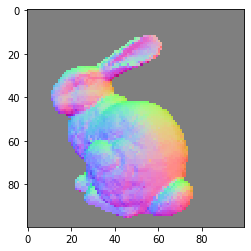

In [17]:
def _(render_index_result):
    vertices, triangles = load_ply('data/bunny/reconstruction/bun_zipper_res2.ply')
    h, w = render_index_result.shape
    result = np.zeros((h, w, 3), dtype=np.float)
    for x in range(w):
        for y in range(h):    
            index = render_index_result[y, x]
            if index == -1: continue
            v0, v1, v2 = vertices[triangles[index]]
            normal = np.cross(v1 - v0, v2 - v0);  normal = normal / np.linalg.norm(normal)
            result[y, x] = normal
    return result

_0 = _(_render_result[1])
plt.imshow(0.5 + 0.5 * _0)